В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
!wget https://raw.githubusercontent.com/trimm-trabb/PythonML/main/bank_churn_preprocessing.py
!pip install opendatasets --upgrade --quiet

--2024-07-15 09:56:01--  https://raw.githubusercontent.com/trimm-trabb/PythonML/main/bank_churn_preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462 (6.3K) [text/plain]
Saving to: ‘bank_churn_preprocessing.py’

bank_churn_preproce 100%[===================>]   6.31K  --.-KB/s    in 0s      

2024-07-15 09:56:01 (68.2 MB/s) - ‘bank_churn_preprocessing.py’ saved [6462/6462]



In [2]:
from bank_churn_preprocessing import preprocess_data, preprocess_new_data
import opendatasets as od
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [4]:
pd.options.display.max_columns = None

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data?select=train.csv'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anastasiiakhartynova
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 50.8MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [4]:
data_dir = './bank-customer-churn-prediction-dlu'
train_csv = data_dir + '/train.csv'
test_csv =  data_dir + '/test.csv'
sample_submission_csv =  data_dir + '/sample_submission.csv'

In [5]:
raw_df = pd.read_csv(train_csv)
datasets, input_cols, scaler, encoder = preprocess_data(raw_df, 'Exited', ['id', 'CustomerId'], ['Surname'], scale_numeric=True)
train_X = datasets['train_X']
train_y = datasets['train_y']
val_X = datasets['val_X']
val_y = datasets['val_y']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [6]:
def compute_auroc(model, inputs, targets):
  y_pred = model.predict_proba(inputs)[:, 1]

  return roc_auc_score(targets, y_pred)

In [7]:
knn = KNeighborsClassifier()
knn.fit(train_X, train_y)

KNeighborsClassifier()

In [9]:
print('Train AUROC', compute_auroc(knn, train_X, train_y))
print('Validation AUROC', compute_auroc(knn, val_X, val_y))

Train AUROC 0.9559428457733543
Validation AUROC 0.852585568283147


Модель видає дуже хороший результат на трейн даних, але падіння auroc на валідаційних даних свідчить про певний ступінь перенавчання і high variance. Думаю, поескпериментувавши з гіперпараметрами, ми могли би отримати кращу модель.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [10]:
k_values = np.arange(3, 40)
param_grid = {'n_neighbors': k_values}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="roc_auc")

In [11]:
grid_search_knn.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39])},
             scoring='roc_auc')

In [12]:
grid_search_knn.best_params_, grid_search_knn.best_score_

({'n_neighbors': 19}, 0.8853000771869176)

In [13]:
knn_best = grid_search_knn.best_estimator_
knn_best.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=19)

In [14]:
print('Train AUROC', compute_auroc(knn_best, train_X, train_y))
print('Validation AUROC', compute_auroc(knn_best, val_X, val_y))

Train AUROC 0.9227310044165035
Validation AUROC 0.8908141847863366


Ця модель видає суттєво кращий результат на валідаційних даних в порівнянні з першою, але дерево прийняття рішень працювало ще краще.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [15]:
max_depth_list = np.arange(1, 21, 2)
max_leaf_nodes_list = np.arange(2, 11, 1)

param_grid = {'max_depth': max_depth_list, 'max_leaf_nodes': max_leaf_nodes_list}

grid_search_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring="roc_auc")

In [16]:
%%time
grid_search_tree.fit(train_X, train_y)

CPU times: user 6.88 s, sys: 17.3 ms, total: 6.9 s
Wall time: 7 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='roc_auc')

In [18]:
grid_search_tree.best_params_, grid_search_tree.best_score_

({'max_depth': 5, 'max_leaf_nodes': 10}, 0.9013929183420709)

In [19]:
dt_best = grid_search_tree.best_estimator_
dt_best.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=42)

In [20]:
print('Train AUROC', compute_auroc(dt_best, train_X, train_y))
print('Validation AUROC', compute_auroc(dt_best, val_X, val_y))

Train AUROC 0.9014754782174744
Validation AUROC 0.9002184649152891


Модель має хороші і дуже подібні результати на тренувальних і валідаційних даних, що свідчить про те, що вона добре генералізує на нових, невідомих даних, і що вона не просто запам’ятала навчальні дані, але й ефективно вивчила базові закономірності в них.

В попередньому дз я вручну шукала параметри в дещо іншому діапазоні значень і найкращий результат дала комбінація max_depth: 8, max_leaf_nodes:47 з AUROC на валідаційному сеті 0.9249.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [39]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [40]:
random_search_tree = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    params_dt,
    n_iter=40,
    cv=cv_strategy,
    scoring="roc_auc",
    random_state=42,
    refit=True
)

In [41]:
%%time
random_search_tree.fit(train_X, train_y)

CPU times: user 1.97 s, sys: 7.73 ms, total: 1.98 s
Wall time: 1.98 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42), n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [42]:
random_search_tree.best_params_, random_search_tree.best_score_

({'splitter': 'best',
  'min_samples_split': 20,
  'min_samples_leaf': 2,
  'max_leaf_nodes': 14,
  'max_features': None,
  'max_depth': 16,
  'criterion': 'entropy'},
 0.9102569441552492)

In [43]:
dt_random_search_best = random_search_tree.best_estimator_
dt_random_search_best.fit(train_X, train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)

In [55]:
print('Train AUROC', compute_auroc(dt_random_search_best, train_X, train_y))
print('Validation AUROC', compute_auroc(dt_random_search_best, val_X, val_y))

Train AUROC 0.9169275635848141
Validation AUROC 0.9166204815145071


Порівняння параметрів:

In [45]:
params_best = dt_best.get_params()
params_random_search_best = dt_random_search_best.get_params()

df_best = pd.DataFrame([params_best], index=['dt_best'])
df_random_search_best = pd.DataFrame([params_random_search_best], index=['dt_random_search_best'])
df_combined = pd.concat([df_best, df_random_search_best])

df_combined

,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,random_state,splitter
dt_best,0.0,None,gini,5,None,10,0.0,1,2,0.0,42,best
dt_random_search_best,0.0,None,entropy,16,None,14,0.0,2,20,0.0,42,best


Модель dt_random_search_best є більш складною (з max_depth 16 проти 5 у dt_best і max_leaf_nodes 14 проти 10), але при цьому вищі min_samples_split (20 проти 2) і min_samples_leaf (2 проти 1) допомагають боротись з перенавчанням, і успішно, адже бачимо, що незважаючи на доволі великі глибину і кількість leaf nodes, модель має дуже подібні значення auroc на тренувальних і валідаційних датасетах, а отже добре генералізує на нових даних. Модель dt_best є простішою, і має трохи гірший результат.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

Трохи поекспериментую з іншими значеннями параметрів:

In [96]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(15, 60),
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': [None, 'sqrt', 'log2']
}

In [97]:
search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    params,
    n_iter=40,
    cv=cv_strategy,
    scoring="roc_auc",
    random_state=42,
    refit=True
)

In [98]:
search.fit(train_X, train_y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42), n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25, 30, 40, 50],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [99]:
search.best_params_, search.best_score_

({'splitter': 'best',
  'min_samples_split': 15,
  'min_samples_leaf': 16,
  'max_leaf_nodes': 29,
  'max_features': None,
  'max_depth': 12,
  'criterion': 'entropy'},
 0.9183312099978767)

In [100]:
model = search.best_estimator_
model.fit(train_X, train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=12, max_leaf_nodes=29,
                       min_samples_leaf=16, min_samples_split=15,
                       random_state=42)

In [101]:
print('Train AUROC', compute_auroc(model, train_X, train_y))
print('Validation AUROC', compute_auroc(model, val_X, val_y))

Train AUROC 0.9292648880690313
Validation AUROC 0.9244708141847863


In [102]:
test_raw_df = pd.read_csv(test_csv)
test_X = preprocess_new_data(test_raw_df, input_cols, scaler, encoder)
probas = model.predict_proba(test_X)

In [57]:
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Machine Learning/Data/'
os.chdir(dir)

Mounted at /content/drive


In [83]:
submission = pd.read_csv(sample_submission_csv)
submission.Exited = probas[:,1]
submission.head()
submission.to_csv('submission_dt_random_search.csv', index=False)

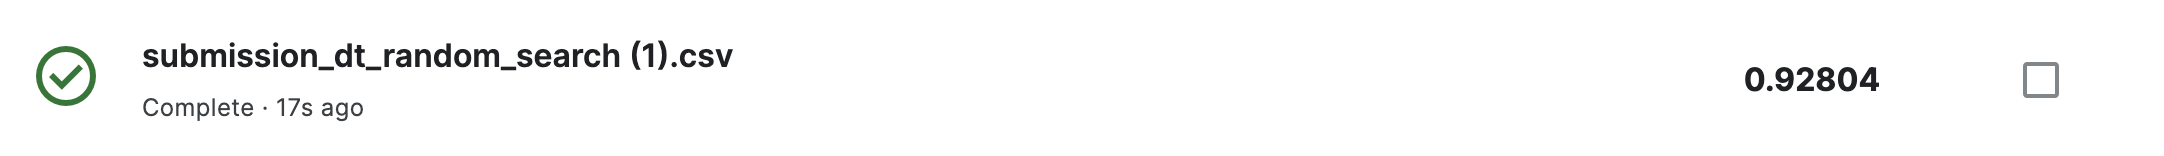